In [ ]:
!pip install scikit-image
!pip install tqdm
!pip install timm

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [6]:
BATCH_SIZE = 32
LR = 0.01
EPOCHS = 100
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
import os
import random
import torch

import pandas as pd
from torch.utils.data import Dataset
from torchvision.io import read_image
from skimage import io

class FishDataset(Dataset):

    df = pd.DataFrame(columns=['anchor', 'positive', 'negative', "a_label", "p_label", "n_label"])

    def __init__(self, image_dirs, transform = None):
        self.transform = transform

        # For each image directory (One dir per class), create a list of tuples (anchor, positive, negative)
        for label, image_dir in enumerate(image_dirs):
            image_paths = os.listdir(image_dir)

            # Ensure that the image_paths are image files .jpg or .png
            image_paths = [path for path in image_paths if path.endswith('.jpg') or path.endswith('.png')]
            
 
            for anchor in image_paths:
               # Select a random positive image
                positive = anchor

                while positive == anchor:
                    positive = random.choice(image_paths)

                # Select a random dir that is not the anchor dir
                neg_idx = random.choice(range(len(image_dirs)))

                while neg_idx == label:
                    neg_idx = random.choice(range(len(image_dirs)))

                negative_dir = image_dirs[neg_idx]

                negative_image_paths = os.listdir(negative_dir)
                negative_image_paths = [path for path in negative_image_paths if path.endswith('.jpg') or path.endswith('.png')]
                
                # Select a random negative image from the negative dir
                negative = random.choice(negative_image_paths)
                
                # Add the tuple to the dataframe
                self.df = self.df.append({
                    'anchor': os.path.join(image_dir, anchor), 
                    'positive': os.path.join(image_dir, positive),
                    'negative': os.path.join(negative_dir, negative), 
                    "a_label": label, 
                    "p_label": label, 
                    "n_label": neg_idx
                }, ignore_index=True)

        self.df.to_csv("data.csv", index=False)


    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # 
        A_img = io.imread(row['anchor'])
        P_img = io.imread(row['positive'])
        N_img = io.imread(row['negative'])

        A_img = torch.from_numpy(A_img).permute(2,0,1) / 255.0
        P_img = torch.from_numpy(P_img).permute(2,0,1) / 255.0
        N_img = torch.from_numpy(N_img).permute(2,0,1) / 255.0

        if self.transform:
            A_img = self.transform(A_img)
            P_img = self.transform(P_img)
            N_img = self.transform(N_img)

        return A_img, P_img, N_img


In [8]:
from torchvision import transforms

transform = transforms.Resize((256, 256))

# Add all directories up to 18
trainset = FishDataset(
    image_dirs=["data/train/01", "data/train/02", "data/train/03","data/train/04","data/train/05"], 
    transform=transform,
)

validset = FishDataset(
    image_dirs=["data/validate/01", "data/validate/02", "data/validate/03","data/validate/04","data/validate/05"], transform=transform,
)

print(f"Size of trainset: {len(trainset)}")
print(f"Size of validset: {len(validset)}")

trainset.df.head()

Size of trainset: 10000
Size of validset: 2500


,anchor,positive,negative,a_label,p_label,n_label
0,data/train/01/1_fish_000004440001_00213.png,data/train/01/1_fish_000026060001_02413.png,data/train/03/3_fish_000033289596_04179.png,0,0,2
1,data/train/01/1_fish_000010229598_05481.png,data/train/01/1_fish_003550335470_25163.png,data/train/05/5_fish_003941976420_11456.png,0,0,4
2,data/train/01/1_fish_004176536832_24040.png,data/train/01/1_fish_003501655379_12031.png,data/train/04/4_fish_000007209599_08117.png,0,0,3
3,data/train/01/1_fish_000027210001_02835.png,data/train/01/1_fish_003658425752_18871.png,data/train/03/3_fish_004277086978_22164.png,0,0,2
4,data/train/01/1_fish_003501535378_10862.png,data/train/01/1_fish_004188816845_15732.png,data/train/02/2_fish_003651605728_24349.png,0,0,1


/home/kjellh14/.local/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


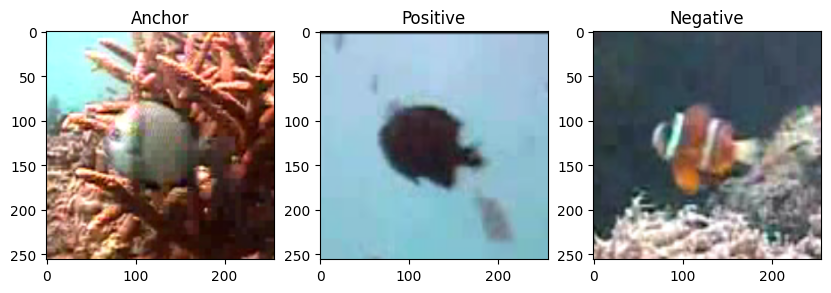

In [9]:
from matplotlib import pyplot as plt

idx = 12

A,P,N = trainset[idx]

f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(10,10))

ax1.set_title("Anchor")
ax1.imshow(A.numpy().transpose(1,2,0))

ax2.set_title("Positive")
ax2.imshow(P.numpy().transpose(1,2,0))

ax3.set_title("Negative")
ax3.imshow(N.numpy().transpose(1,2,0))

In [10]:
from torch.utils.data import DataLoader

trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE)

print(f"No. of batches in trainloader: {len(trainloader)}")
print(f"No. of batches in validloader: {len(validloader)}")  

No. of batches in trainloader: 313
No. of batches in validloader: 79


In [11]:
import timm
from torch import nn

class FishModel(nn.Module):

    def __init__(self, emb_size=1024):
        super(FishModel, self).__init__()

        self.efficientnet = timm.create_model('efficientnet_b0', pretrained=True)

        self.efficientnet.classifier = nn.Linear(
            in_features=self.efficientnet.classifier.in_features, 
            out_features=emb_size
        )

    def forward(self, x):
        embeddings = self.efficientnet(x)
        return embeddings

In [12]:
from tqdm import tqdm
from torch import optim
from torch import nn
from torch.utils.data import DataLoader

def train(model: nn.Module, dataloader: DataLoader, optimizer: optim.Optimizer, criterion: nn.Module):

    model.train()

    total_loss = 0.0

    for A, P, N in tqdm(dataloader):

        A, P, N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)

        A_embs = model(A)
        P_embs = model(P)
        N_embs = model(N)

        loss = criterion(A_embs, P_embs, N_embs)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)


def validate(model: nn.Module, dataloader: DataLoader, criterion: nn.Module):

    model.eval()

    total_loss = 0.0

    with torch.no_grad():
        for A, P, N in tqdm(dataloader):

            A, P, N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)

            A_embs = model(A)
            P_embs = model(P)
            N_embs = model(N)

            loss = criterion(A_embs, P_embs, N_embs)

            total_loss += loss.item()

    return total_loss / len(dataloader)

In [ ]:
import numpy as np

model = FishModel()
model.to(DEVICE)

criterion = nn.TripletMarginLoss()

optimizer = optim.SGD(model.parameters(), lr=LR, momentum=0.9)

best_valid_loss = np.inf

for epoch in range(EPOCHS):
    
    train_loss = train(model, trainloader, optimizer, criterion)
    valid_loss = validate(model, validloader, criterion)

    torch.save(model.state_dict(), 'models/latest.pt')
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'models/best.pt')

    # Save the loss for every epoch in a file called loss.txt
    with open("loss.txt", "a") as f:
        f.write(f"{train_loss},{valid_loss}\n")
    
    print(f"Epoch: {epoch+1}/{EPOCHS} Train Loss: {train_loss:.4f} Valid Loss: {valid_loss:.4f}")



100%|██████████| 79/79 [00:55<00:00,  1.41it/s]


Epoch: 1/100 Train Loss: 0.0707 Valid Loss: 0.0203


100%|██████████| 79/79 [00:56<00:00,  1.40it/s]


Epoch: 2/100 Train Loss: 0.0120 Valid Loss: 0.0122


100%|██████████| 79/79 [01:08<00:00,  1.15it/s]


Epoch: 3/100 Train Loss: 0.0047 Valid Loss: 0.0068


100%|██████████| 79/79 [01:00<00:00,  1.31it/s]


Epoch: 4/100 Train Loss: 0.0028 Valid Loss: 0.0017


100%|██████████| 79/79 [01:01<00:00,  1.28it/s]


Epoch: 5/100 Train Loss: 0.0036 Valid Loss: 0.0006


100%|██████████| 79/79 [00:57<00:00,  1.38it/s]


Epoch: 6/100 Train Loss: 0.0020 Valid Loss: 0.0018


100%|██████████| 79/79 [01:02<00:00,  1.27it/s]


Epoch: 7/100 Train Loss: 0.0016 Valid Loss: 0.0020


100%|██████████| 79/79 [01:00<00:00,  1.30it/s]


Epoch: 8/100 Train Loss: 0.0008 Valid Loss: 0.0017


100%|██████████| 79/79 [01:00<00:00,  1.30it/s]


Epoch: 9/100 Train Loss: 0.0014 Valid Loss: 0.0025


100%|██████████| 79/79 [00:58<00:00,  1.34it/s]


Epoch: 10/100 Train Loss: 0.0012 Valid Loss: 0.0041


100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch: 11/100 Train Loss: 0.0009 Valid Loss: 0.0042


100%|██████████| 79/79 [01:00<00:00,  1.32it/s]


Epoch: 12/100 Train Loss: 0.0005 Valid Loss: 0.0029


100%|██████████| 79/79 [00:59<00:00,  1.32it/s]


Epoch: 13/100 Train Loss: 0.0003 Valid Loss: 0.0061


100%|██████████| 79/79 [00:59<00:00,  1.32it/s]


Epoch: 14/100 Train Loss: 0.0000 Valid Loss: 0.0050


100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch: 15/100 Train Loss: 0.0014 Valid Loss: 0.0021


100%|██████████| 79/79 [00:57<00:00,  1.38it/s]


Epoch: 16/100 Train Loss: 0.0000 Valid Loss: 0.0022


100%|██████████| 79/79 [01:00<00:00,  1.32it/s]


Epoch: 17/100 Train Loss: 0.0008 Valid Loss: 0.0041


100%|██████████| 79/79 [00:57<00:00,  1.38it/s]


Epoch: 18/100 Train Loss: 0.0005 Valid Loss: 0.0017


100%|██████████| 79/79 [00:58<00:00,  1.36it/s]


Epoch: 19/100 Train Loss: 0.0001 Valid Loss: 0.0009


100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch: 20/100 Train Loss: 0.0005 Valid Loss: 0.0024


100%|██████████| 79/79 [01:00<00:00,  1.31it/s]


Epoch: 21/100 Train Loss: 0.0005 Valid Loss: 0.0020


100%|██████████| 79/79 [00:56<00:00,  1.39it/s]


Epoch: 22/100 Train Loss: 0.0003 Valid Loss: 0.0049


100%|██████████| 79/79 [01:00<00:00,  1.30it/s]


Epoch: 23/100 Train Loss: 0.0009 Valid Loss: 0.0038


100%|██████████| 79/79 [00:57<00:00,  1.36it/s]


Epoch: 24/100 Train Loss: 0.0013 Valid Loss: 0.0009


100%|██████████| 79/79 [00:57<00:00,  1.37it/s]


Epoch: 25/100 Train Loss: 0.0005 Valid Loss: 0.0016


100%|██████████| 79/79 [00:57<00:00,  1.38it/s]


Epoch: 26/100 Train Loss: 0.0005 Valid Loss: 0.0009


100%|██████████| 79/79 [00:58<00:00,  1.36it/s]


Epoch: 27/100 Train Loss: 0.0002 Valid Loss: 0.0047


100%|██████████| 79/79 [00:56<00:00,  1.40it/s]


Epoch: 28/100 Train Loss: 0.0006 Valid Loss: 0.0024


100%|██████████| 79/79 [00:58<00:00,  1.36it/s]


Epoch: 29/100 Train Loss: 0.0003 Valid Loss: 0.0023


100%|██████████| 79/79 [00:58<00:00,  1.34it/s]


Epoch: 30/100 Train Loss: 0.0001 Valid Loss: 0.0028


100%|██████████| 79/79 [00:59<00:00,  1.34it/s]


Epoch: 31/100 Train Loss: 0.0005 Valid Loss: 0.0011


100%|██████████| 79/79 [00:58<00:00,  1.34it/s]


Epoch: 32/100 Train Loss: 0.0005 Valid Loss: 0.0017


100%|██████████| 79/79 [00:58<00:00,  1.35it/s]


Epoch: 33/100 Train Loss: 0.0000 Valid Loss: 0.0011


100%|██████████| 79/79 [00:58<00:00,  1.35it/s]


Epoch: 34/100 Train Loss: 0.0003 Valid Loss: 0.0010


100%|██████████| 79/79 [00:57<00:00,  1.36it/s]


Epoch: 35/100 Train Loss: 0.0001 Valid Loss: 0.0007


100%|██████████| 79/79 [00:56<00:00,  1.39it/s]


Epoch: 36/100 Train Loss: 0.0007 Valid Loss: 0.0016


100%|██████████| 79/79 [00:58<00:00,  1.34it/s]


Epoch: 37/100 Train Loss: 0.0003 Valid Loss: 0.0005


100%|██████████| 79/79 [00:55<00:00,  1.42it/s]


Epoch: 38/100 Train Loss: 0.0003 Valid Loss: 0.0003


100%|██████████| 79/79 [00:57<00:00,  1.37it/s]


Epoch: 39/100 Train Loss: 0.0003 Valid Loss: 0.0001


100%|██████████| 79/79 [00:57<00:00,  1.36it/s]


Epoch: 40/100 Train Loss: 0.0004 Valid Loss: 0.0006


100%|██████████| 79/79 [00:56<00:00,  1.39it/s]


Epoch: 41/100 Train Loss: 0.0006 Valid Loss: 0.0000


100%|██████████| 79/79 [00:58<00:00,  1.36it/s]


Epoch: 42/100 Train Loss: 0.0004 Valid Loss: 0.0007


100%|██████████| 79/79 [00:57<00:00,  1.37it/s]


Epoch: 43/100 Train Loss: 0.0001 Valid Loss: 0.0012


100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch: 44/100 Train Loss: 0.0002 Valid Loss: 0.0001


100%|██████████| 79/79 [00:58<00:00,  1.36it/s]


Epoch: 45/100 Train Loss: 0.0007 Valid Loss: 0.0003


100%|██████████| 79/79 [01:04<00:00,  1.23it/s]


Epoch: 46/100 Train Loss: 0.0000 Valid Loss: 0.0004


100%|██████████| 79/79 [01:05<00:00,  1.21it/s]


Epoch: 47/100 Train Loss: 0.0003 Valid Loss: 0.0011


 80%|███████▉  | 249/313 [03:57<01:04,  1.00s/it]

In [84]:

model = FishModel()
model.load_state_dict(torch.load('best.pt'))

# For each file in the "reference" folder, calculate the embeddings

embeddings = []

for file in os.listdir("references"):
    img = io.imread(os.path.join("references", file))
    img = torch.from_numpy(img).permute(2,0,1) / 255.0
    img = transform(img).unsqueeze(0)

    # Get the embeddings
    emb = model(img)

    embeddings.append(emb.detach().numpy())


# For each file in the "data/test" folder, predict the class
for file in os.listdir("data/test"):
    img = io.imread(os.path.join("data/test", file))
    img = torch.from_numpy(img).permute(2,0,1) / 255.0
    img = transform(img).unsqueeze(0)

    # Get the embeddings
    emb = model(img)

    # Calculate the euclidean distance between the embeddings of the test image and the reference images
    distances = [np.linalg.norm(emb.detach().numpy() - e) for e in embeddings]

    # Get the index of the reference image with the smallest distance
    pred = np.argmin(distances)

    print(f"Predicted class: {pred} Distance: {distances[pred]}")



Predicted class: 0 Distance: 1.2903664112091064
Predicted class: 0 Distance: 1.0943541526794434
Predicted class: 1 Distance: 1.0428030490875244
Predicted class: 0 Distance: 1.1918766498565674
